In [1]:
# jupyter specific magic operator
%pylab inline
import matplotlib.patches as mpatches
# import numpy as np
# from numpy import *
# import matplotlib.pyplot as plt
from becquerel import Spectrum
import os
from copy import deepcopy
import numpy as np
from gamma_energies import gamma_energies
from calibration import spectrum_calibration
from lmfit.models import GaussianModel
from lmfit.models import LinearModel
import operator

Populating the interactive namespace from numpy and matplotlib


# File names
The following two cells are creating arrays of all the files. 
How to interpret the file name: digibase_5min_0_1.Spe This is from the digibase at a 0 zero angle from the detector so straight on in x and the 1 refers to the first run. 30 means a 30 degree offset and so forth.

In [2]:
fname1 = ['Data_collection/digibase_5min_0_1.Spe', 'Data_collection/digibase_5min_30_1.Spe', \
         'Data_collection/digibase_5min_60_1.Spe', \
         'Data_collection/digibase_5min_90_1.Spe','Data_collection/digibase_5min_30_2.Spe',  \
         'Data_collection/digibase_5min_60_2.Spe', \
         'Data_collection/digibase_5min_90_2.Spe', 'Data_collection/digibase_5min_0_2.Spe']

In [3]:
fname2 = ['Data_collection/analog_vs_digital/analog_5min_0_1.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_60_1.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_30_1.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_90_1.Spe', \
          'Data_collection/analog_vs_digital/analog_5min_0_2.Spe', \
          'Data_collection/analog_vs_digital/analog_5min_30_2.Spe', \
        'Data_collection/analog_vs_digital/analog_5min_60_2.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_90_2.Spe']

# Fix Spe file
Since the data was not calibrated in gamma vision, the below function adds 1's to MCA_Cal so Bq runs. It writes the 1's to a new filename while preserving the original data. 

In [4]:
def fix_spe_zero_cal(fname, fname_new=None):
    if fname_new is None:
        fname_new = '{}_fixed{}'.format(*os.path.splitext(fname))
    with open(fname, 'r') as infile:
        old_lines = [l.rstrip('\n') for l in infile]
    new_lines = deepcopy(old_lines)
    for i, l in enumerate(old_lines):
        if l.startswith('$MCA_CAL'):
            cal = [float(x) for x in old_lines[i + 2].split()]
            if np.isclose(sum(cal), 0.):
                new_lines[i + 2] = '1.0 1.0 1.0'
                print('Fixed line:', i + 2)

    with open(fname_new, 'w') as infile:
        infile.write('\n'.join(new_lines) + '\n')

    return fname_new

# Background Subtraction

Background was run for 30 minutes
Measurements lasted for 5 minutes
The data is normalized to time

In [5]:
time_1 = 5
time_2 = 30
fname = 'Data_collection/digibase_5min_0_1.Spe'
digital_0_1 = Spectrum.from_file(fix_spe_zero_cal(fname))
#Background Subtraction
fname = 'Data_collection/digibase_30min_bg.Spe'
spec_bg = Spectrum.from_file(fix_spe_zero_cal(fname))
spec_bg = spec_bg.counts_vals*time_1/time_2
bgsub_digital = digital_0_1.counts_vals - spec_bg

Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_0_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_30min_bg_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0


# Measurement Information

In [6]:
print(digital_0_1.start_time)
print(digital_0_1.stop_time)
print(digital_0_1.realtime)
print(digital_0_1.livetime)

2018-02-09 09:57:31
2018-02-09 10:02:33
302.0
299.0


# Calibrating the Data

SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_0_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_30min_bg.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0


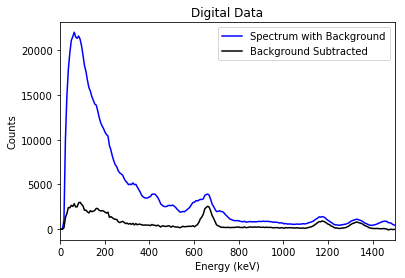

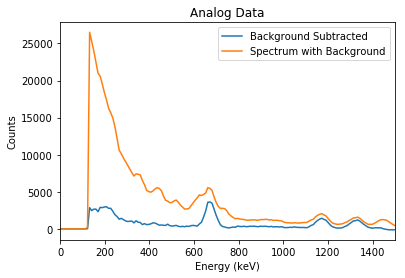

In [7]:
fig, ax = plt.subplots()

data_2_calibrate = digital_0_1.counts_vals
channel_width = 20; clean_left = 0; clean_right = 90; energy_list = gamma_energies('Cs137', 'Co60')
slope_d, intercept_d = spectrum_calibration(channel_width, energy_list, data_2_calibrate, clean_left, clean_right)
calibrated_channel = []
for i in range(0,len(digital_0_1.counts_vals)):
    calibrated_channel += [i*slope_d+ intercept_d]
calibrated_channel = np.array(calibrated_channel, 'float')


plt.plot(calibrated_channel, digital_0_1.counts_vals, 'b', label = 'Spectrum with Background')
plt.plot(calibrated_channel, bgsub_digital, 'k', label = 'Background Subtracted')
plt.xlim(0,1500, 50)
title('Digital Data')
xlabel('Energy (keV)')
ylabel('Counts')
plt.legend()

fname = 'Data_collection/analog_vs_digital/analog_5min_0_1.Spe'
spec_1_analog = Spectrum.from_file((fname))
data_2_calibrate = spec_1_analog.counts_vals
channel_width = 15; clean_left = 0; clean_right = 60
slope_a, intercept_a = spectrum_calibration(channel_width, energy_list, data_2_calibrate, clean_left, clean_right)
calibrated_channel_a = []
for i in range(0,len(spec_1_analog.counts_vals)):
    calibrated_channel_a += [i*slope_a+ intercept_a]
calibrated_channel_a = np.array(calibrated_channel_a, 'float')

#Background Subtraction
fname = 'Data_collection/analog_vs_digital/analog_30min_bg.Spe'
spec_bg_analog = Spectrum.from_file((fname))
spec_bg_analog = spec_bg_analog.counts_vals*time_1/time_2
bgsub_analog = spec_1_analog.counts_vals - spec_bg_analog
fig, ax = plt.subplots()
title('Analog Data')
xlabel('Energy (keV)')
ylabel('Counts')
plt.xlim(0,1500,50)
plt.plot(calibrated_channel_a, bgsub_analog, label = 'Background Subtracted')
plot(calibrated_channel_a, spec_1_analog.counts_vals, label = 'Spectrum with Background')
plt.legend()

# Merging the analog and digital spectrums

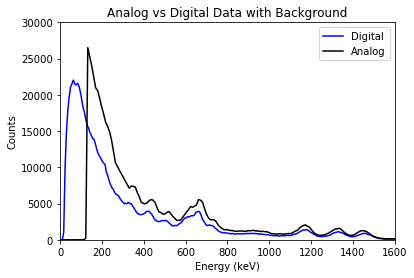

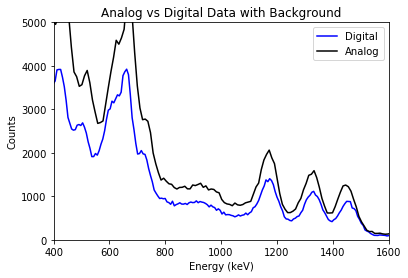

In [8]:
plt.plot(calibrated_channel, digital_0_1.counts_vals, 'b', label = 'Digital')
plot(calibrated_channel_a, spec_1_analog.counts_vals, 'k', label = 'Analog')
title('Analog vs Digital Data with Background')
xlabel('Energy (keV)')
ylabel('Counts')
plt.xlim(0,1600,50)
plt.ylim(0,30000,500)
plt.legend()
plt.show()
plt.plot(calibrated_channel, digital_0_1.counts_vals, 'b', label = 'Digital')
plot(calibrated_channel_a, spec_1_analog.counts_vals, 'k', label = 'Analog')
title('Analog vs Digital Data with Background')
xlabel('Energy (keV)')
ylabel('Counts')
plt.xlim(400,1600,50)
plt.ylim(0,5000,500)
plt.legend()

# Function to read Gaussian output from Lmfit

In [9]:
def gauss_parameters_analyzer(gauss_parameters):
    stderr_list = []; Uncal_energy_list = []; gauss_parameters_list = []
    center_list = []; amplitude_list = []; fwhm_list = []; height_list = []
    for i in range(len(gauss_parameters)):
        Uncal_energy, Counts, parameters = zip(gauss_parameters[i])
        Uncal_energy = np.asarray(Uncal_energy)
        Uncal_energy_list.append(Uncal_energy)
        stderr = np.asarray(parameters[0])
        stderr_list.append(stderr[0])
        stderr = np.asarray(stderr_list)
        center = np.asarray(parameters[0])
        center_list.append(center[1])
        center = np.asarray(center_list)
        amplitude = np.asarray(parameters[0])
        amplitude_list.append(amplitude[2])
        amplitude = np.asarray(amplitude_list)
        fwhm = np.asarray(parameters[0])
        fwhm_list.append(fwhm[3])
        fwhm = np.asarray(fwhm_list)
        height = np.asarray(parameters[0])
        height_list.append(height[4])
        height = np.asarray(height_list)
        return Uncal_energy, stderr, center, amplitude, fwhm, height

# Fitting the Data with a Gauss function and a linear subtraction

The following cell calibrates the raw spectrum for both the analog and digital system. It requires some knowledge of the spectrum. Clean left and clean right remove the noise at the beginning of the spectrum. 
For the digital system, it will turn all of the peaks before channel 100 to 0. It will then rely on Cs137 and Co60 to calibrate the output
The analog system is similar. 

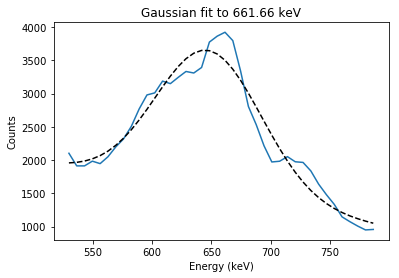

[ 36566.68407406] [ 36645.57022054]


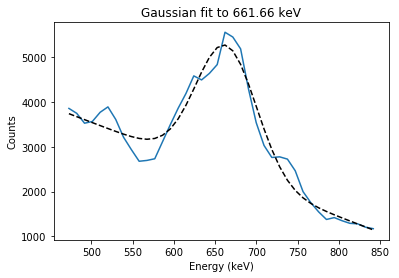

[ 28022.62216007] [ 28083.07600576]


In [14]:
energy_spectrum = gamma_energies('Cs137')
energy_spectrum = sorted(energy_spectrum, key=int)
from gauss_peak_fit import spectrum_gauss_fit

channel_width = 20
clean_left = 0
clean_right = 70
bgsub_array = digital_0_1.counts_vals

gauss_parameters = spectrum_gauss_fit(bgsub_array, clean_left, clean_right, \
                   channel_width, energy_spectrum, slope_d, intercept_d)

Uncal_energy, stderr, center, amplitude, fwhm, height = gauss_parameters_analyzer(gauss_parameters)

Area = height * fwhm/(2.35*0.3989)
print(amplitude, Area)

data_2_calibrate = spec_1_analog.counts_vals
channel_width = 20; clean_left = 0; clean_right = 45
gauss_parameters = spectrum_gauss_fit(data_2_calibrate, clean_left, clean_right, \
                   channel_width, energy_spectrum, slope_a, intercept_a)

Uncal_energy, stderr, center, amplitude, fwhm, height = gauss_parameters_analyzer(gauss_parameters)

Area = height * fwhm/(2.35*0.3989)
print(amplitude, Area)

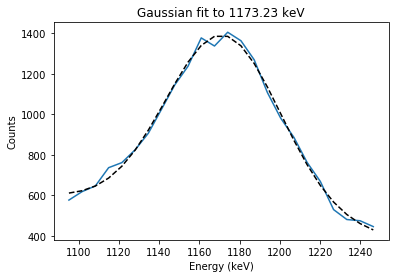

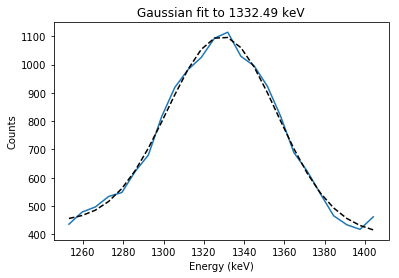

[ 9797.18113566] [ 9818.3168193]


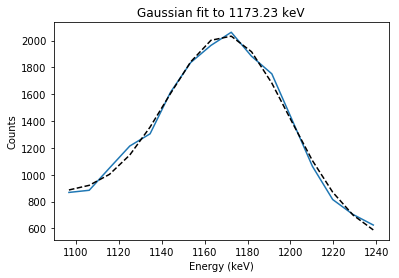

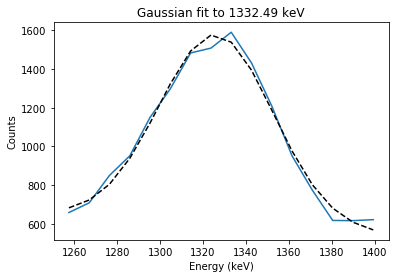

[ 10351.14674656] [ 10373.47751291]


In [22]:
energy_spectrum = gamma_energies('Co60')
energy_spectrum = sorted(energy_spectrum, key=int)
from gauss_peak_fit import spectrum_gauss_fit

channel_width = 12
clean_left = 0
clean_right = 150
bgsub_array = digital_0_1.counts_vals

gauss_parameters = spectrum_gauss_fit(bgsub_array, clean_left, clean_right, \
                   channel_width, energy_spectrum, slope_d, intercept_d)

Uncal_energy, stderr, center, amplitude, fwhm, height = gauss_parameters_analyzer(gauss_parameters)

Area = height * fwhm/(2.35*0.3989)
print(amplitude, Area)

data_2_calibrate = spec_1_analog.counts_vals
channel_width = 8; clean_left = 0; clean_right = 110
gauss_parameters = spectrum_gauss_fit(data_2_calibrate, clean_left, clean_right, \
                   channel_width, energy_spectrum, slope_a, intercept_a)

Uncal_energy, stderr, center, amplitude, fwhm, height = gauss_parameters_analyzer(gauss_parameters)

Area = height * fwhm/(2.35*0.3989)
print(amplitude, Area)

# Plotting the different degrees of NaI bar orientation

0
100000
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_0_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_0_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_30_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_60_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_60_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_30_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
0
100000
Fixed line: 1046
SpeFil

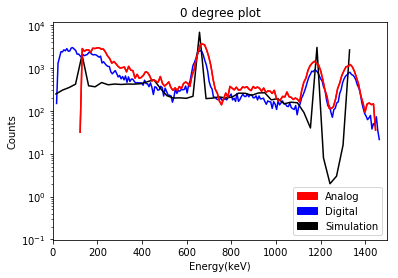

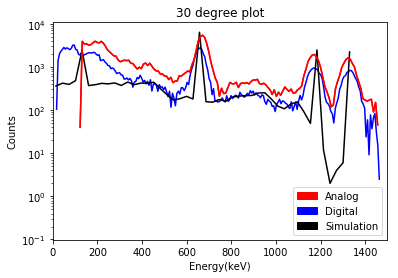

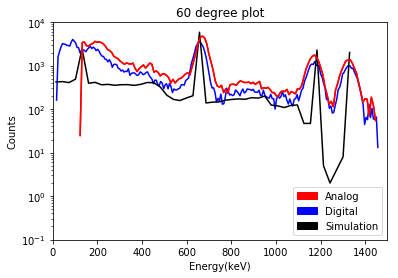

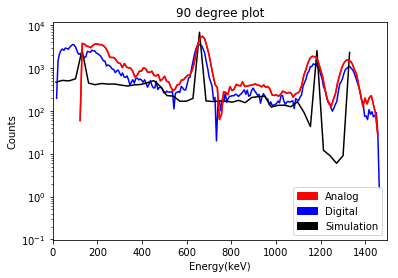

In [11]:
figure_counter=0; count_list = []; bin_centers_list = []
from sim_reader import cosima_output
fname = ['NaI_Tl_detector.inc5.id1.sim', 'NaI_Tl_detector.inc6.id1.sim', \
         'NaI_Tl_detector.inc7.id1.sim', 'NaI_Tl_detector.inc8.id1.sim']
angles = ['0', '30', '60', '90']
for i in arange(len(fname)):
    plt.figure(i)
    bin_centers1, counts1 = cosima_output(fname[i])
    plt.semilogy(bin_centers1, counts1, 'k', zorder = 10)

    spec_2 = Spectrum.from_file(fix_spe_zero_cal(fname1[i]))
    bgsub2 = spec_2.counts_vals - spec_bg
    plt.semilogy(calibrated_channel, bgsub2, 'b', zorder = 0)

    spec_2 = Spectrum.from_file(fname2[i])
    bgsub2 = spec_2.counts_vals - spec_bg_analog
    plt.semilogy(calibrated_channel_a, bgsub2, 'r', zorder = 10)
        
    plt.ylabel("Counts")
    plt.xlabel("Energy(keV)")
    plt.title("%s degree plot" % angles[i])
    plt.xlim(0,1500, 50)
    plt.semilogy(calibrated_channel_a, bgsub2, 'r', zorder = 10)
    red_patch = mpatches.Patch(color='Red', label='Analog')
    red_patch1 = mpatches.Patch(color='Blue', label='Digital')
    red_patch2 = mpatches.Patch(color='Black', label='Simulation')
    plt.legend(handles=[red_patch, red_patch1, red_patch2],loc="lower right")

In [12]:
for i in range(len(energy_list)):
    cal_energy_list = Uncal_energy_list[i] * slope + intercept
    plt.plot(cal_energy_list, stderr[i], 'o--')
plt.title('Energy Resolution for Digital')
plt.xlabel('Energy (keV)')
plt.ylabel('Standard Deviation')


data_2_calibrate = bgsub_analog
channel_width = 15; clean_left = 0; clean_right = 50
slope, intercept = spectrum_calibration(channel_width, energy_list, data_2_calibrate, clean_left, clean_right)

for i in range(len(energy_list)):
    cal_energy_list = Uncal_energy_list[i] * slope + intercept
    plt.plot(cal_energy_list, stderr[i], '--')
plt.title('Energy Resolution for Analog')
plt.xlabel('Energy (keV)')
plt.ylabel('Standard Deviation')

NameError: name 'Uncal_energy_list' is not defined